In [20]:
import numpy as np
from skimage.data import camera
import matplotlib.pyplot as plt

In [3]:
x = np.array(camera()).reshape(1, 1, 512, 512)
w = np.concatenate((np.array([[1, 2, 1], [0, 0, 0],
                              [-1, -2, -1]]).reshape(1, 1, 3, 3),
                    np.array([[1, 0, -1], [2, 0, -2],
                              [1, 0, -1]]).reshape(1, 1, 3, 3)))

print(f'Image Shape: {x.shape}')
print(f'Filter Shape: {w.shape}')

Image Shape: (1, 1, 512, 512)
Filter Shape: (2, 1, 3, 3)


Oppgave 1a
The image has N = 1 indicating that one image is to be processed as a batch at a time
Image has C = 1 indicating grayscale image
Height and width is 512.

The filter has Cout = 2
Cin = 1
and width and height of 3

Applying a 3x3 filter with stride of 1 results in a 510x510 image, so we have to zero pad by 1 pixel on each side.

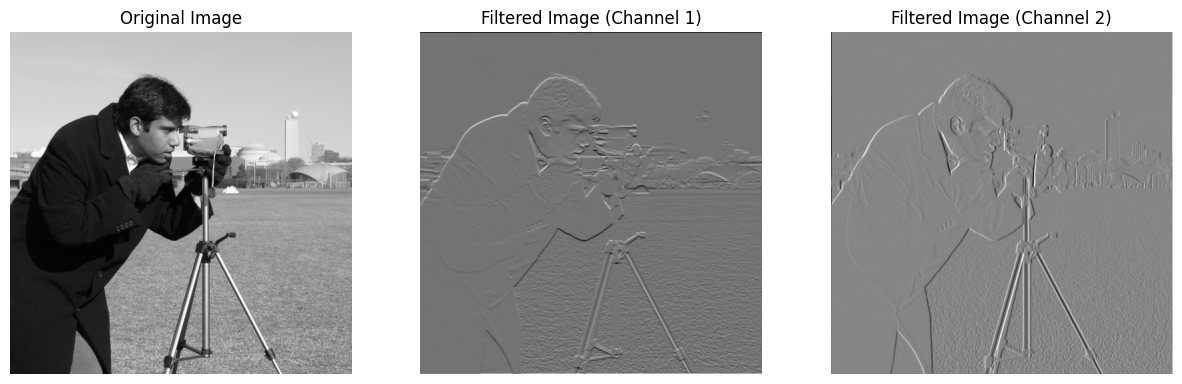

In [ ]:
# TASK 1B

def visualize_convolution(x, output):
    N, C, H, W = x.shape  # Input image dimensions
    N, M, H, W = output.shape  # Output image dimensions
    
    fig, axes = plt.subplots(1, M+1, figsize=(15, 5))
    
    # Display original image (grayscale)
    axes[0].imshow(x[0, 0], cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Display each output channel
    for i in range(M):
        axes[i+1].imshow(output[0, i], cmap='gray')
        axes[i+1].set_title(f"Filtered Image (Channel {i+1})")
        axes[i+1].axis("off")
    
    plt.show()

def convolve(x, w):
    N, C, H, W = x.shape
    M, _, F, _ = w.shape
    padding = F // 2 

    x_padded = np.pad(x, pad_width=((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant', constant_values=0)

    filtered_image = np.zeros((N, M, H, W))

    for i in range(H):
        for j in range(W):
            region = x_padded[:, :, i:i+F, j:j+F] 
            filtered_image[:, :, i, j] = np.sum(region * w, axis=(1, 2, 3))

    return filtered_image

output = convolve(x, w)

visualize_convolution(x, output)

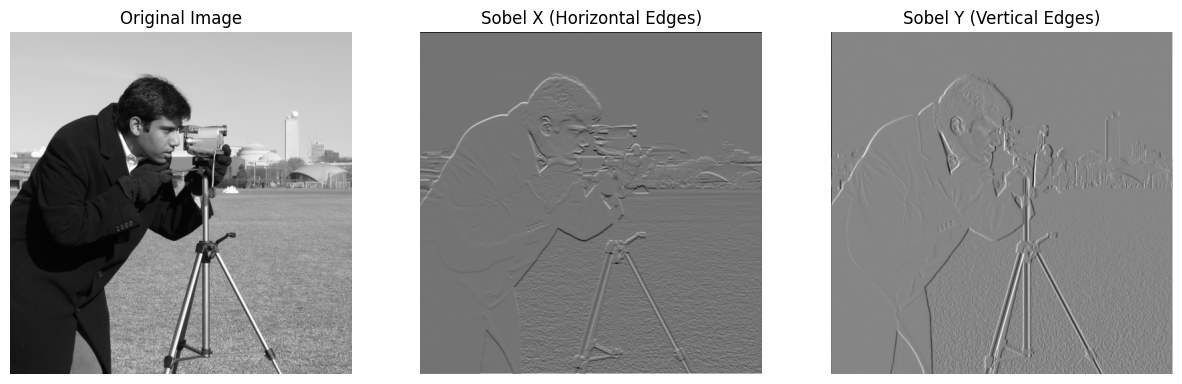

In [29]:

# Load the image and reshape it properly
x = np.array(camera()).reshape(1, 1, 512, 512)

# Define Sobel filters for edge detection
w = np.concatenate((
    np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).reshape(1, 1, 3, 3),
    np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).reshape(1, 1, 3, 3)
))

def im2col(x, filter_h, filter_w, stride=1):
    """
    Converts an image into column format to facilitate convolution operations.
    
    Parameters:
    - x: Input image (N, C, H, W)
    - filter_h: Filter height
    - filter_w: Filter width
    - stride: Stride size
    
    Returns:
    - A reshaped 2D matrix of image patches.
    """
    N, C, H, W = x.shape
    out_h = (H - filter_h) // stride + 1
    out_w = (W - filter_w) // stride + 1

    # Initialize column matrix
    cols = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x_idx in range(filter_w):  # Renamed 'x' to 'x_idx'
            x_max = x_idx + stride * out_w
            cols[:, :, y, x_idx, :, :] = x[:, :, y:y_max:stride, x_idx:x_max:stride]

    cols = cols.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return cols

def convolve_im2col(x, w, stride=1, pad=1):
    """
    Performs convolution using im2col.
    
    Parameters:
    - x: Input image (N, C, H, W)
    - w: Filters (F, C, HH, WW)
    - stride: Stride size
    - pad: Padding size
    
    Returns:
    - Convolved output (N, F, H_out, W_out)
    """
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape

    # Apply padding
    pad = HH // 2  # Ensures same spatial resolution
    x_padded = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)

    # Compute output dimensions
    out_h = (H + 2 * pad - HH) // stride + 1
    out_w = (W + 2 * pad - WW) // stride + 1

    # Convert image to column format
    x_col = im2col(x_padded, HH, WW, stride)

    # Reshape filters into columns
    w_col = w.reshape(F, -1).T

    # Perform matrix multiplication
    out = np.dot(x_col, w_col)

    # Reshape output to match expected dimensions
    out = out.reshape(N, out_h, out_w, F).transpose(0, 3, 1, 2)

    return out


# Perform convolution
output = convolve_im2col(x, w, stride=1, pad=1)

# Extract Sobel X and Sobel Y responses
sobel_x = output[0, 0]  # First channel (horizontal edges)
sobel_y = output[0, 1]  # Second channel (vertical edges)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original Image
axes[0].imshow(x[0, 0], cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Sobel X (Horizontal Edges)
axes[1].imshow(sobel_x, cmap='gray')
axes[1].set_title("Sobel X (Horizontal Edges)")
axes[1].axis("off")

# Sobel Y (Vertical Edges)
axes[2].imshow(sobel_y, cmap='gray')
axes[2].set_title("Sobel Y (Vertical Edges)")
axes[2].axis("off")

plt.show()